# Preparing

### Import everything needed

In [199]:
from collections import Counter
import csv
from itertools import groupby
import random

import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as sndi

%matplotlib inline

### Define all global varaibles

In [200]:
drive_log_file = 'driving_log.csv'

# raw data
X_center = []
X_left = []
X_right = []
y_steering = []

# processed data
X_train = np.array([]) # path to the image
X_flag = np.array([]) # flag for idicating the image need to be flipped or not
y_train = np.array([]) # steering angle while the image was captured

### Define some helper function

In [201]:
def show_steering_angle_distribution(y_train, groups = 2000):
    plt.title("Steering angle distribution in training data")
    plt.hist(y_train, groups)
    plt.show()

# Read raw data

In [202]:
with open(drive_log_file, 'rt') as csvfile:
    reader = csv.reader(csvfile, skipinitialspace=True)

    next(reader) # skip the first row
    
    i = 0
    for row in reader:
        i = i+1
        X_center.append(row[0])
        X_left.append(row[1])
        X_right.append(row[2])
        y_steering.append(float(row[3]))


X_center = np.array(X_center)
X_left = np.array(X_left)
X_right = np.array(X_right)
y_steering = np.array(y_steering)

# Exploring

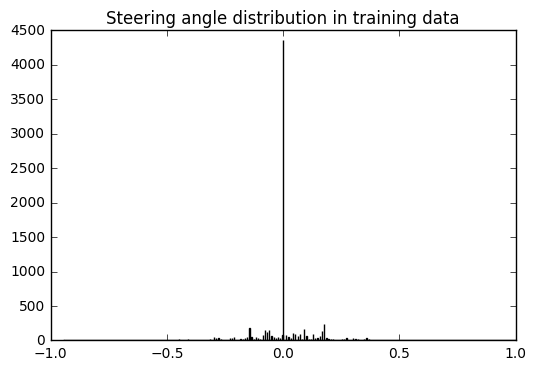

number of positive angle: 1900
number of negative angle: 1775
number of zero angle: 4361


In [203]:
show_steering_angle_distribution(y_steering)

positive_angle = [i for i in y_steering if i > 0]
nagative_angle = [i for i in y_steering if i < 0]
zero_angle = [i for i in y_steering if i == 0]

print('number of positive angle:', len(positive_angle))
print('number of negative angle:', len(nagative_angle))
print('number of zero angle:', len(zero_angle))

# Preprocessing

## Use side camera images

In [204]:
X_train = np.append(X_center, X_left, axis=0)
X_flag = np.append(np.zeros((len(X_center))), np.zeros((len(X_left))), axis=0)
y_train = np.append(y_steering, y_steering+0.15, axis=0)

X_train = np.append(X_train, X_right, axis=0)
X_flag = np.append(X_flag, np.zeros((len(X_right))), axis=0)
y_train = np.append(y_train, y_steering-0.15, axis=0)

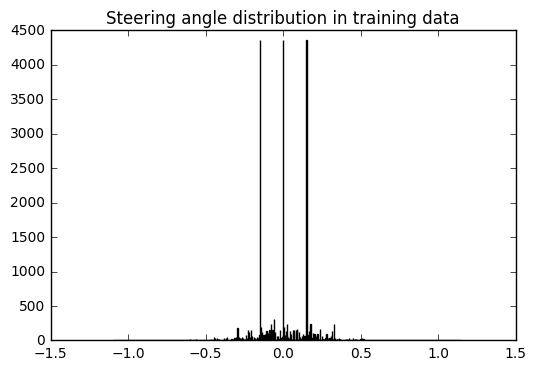

number of positive angle: 10245
number of negative angle: 9502
number of zero angle: 4361


In [205]:
show_steering_angle_distribution(y_train)

positive_angle = [i for i in y_train if i > 0]
nagative_angle = [i for i in y_train if i < 0]
zero_angle = [i for i in y_train if i == 0]

print('number of positive angle:', len(positive_angle))
print('number of negative angle:', len(nagative_angle))
print('number of zero angle:', len(zero_angle))

## Flip the image horizontally

In [206]:
X_flag = np.append(X_flag, np.ones((len(X_train))), axis=0) # X_flag should be appended before X_train
X_train = np.append(X_train, X_train, axis=0)
y_train = np.append(y_train, -y_train, axis=0)

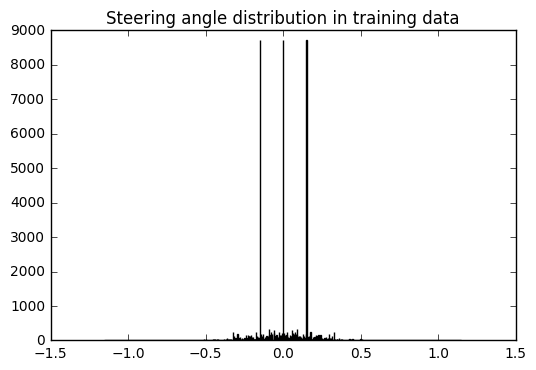

number of positive angle: 19747
number of negative angle: 19747
number of zero angle: 8722


In [207]:
show_steering_angle_distribution(y_train)

positive_angle = [i for i in y_train if i > 0]
nagative_angle = [i for i in y_train if i < 0]
zero_angle = [i for i in y_train if i == 0]

print('number of positive angle:', len(positive_angle))
print('number of negative angle:', len(nagative_angle))
print('number of zero angle:', len(zero_angle))

## Select some of the data for training

### Limit the max number of sample of each steering angle range

In [208]:
max_keep = 500

In [209]:
for i in np.arange(-1.5, 1.5, 0.001):
    rounded_y_train = np.round(y_train, 3)
    i = np.round(i, 3)
    indices = np.where(rounded_y_train == i)[0]
    if len(indices) > max_keep:
        indices_to_be_deleted = indices[random.sample(range(len(indices)), len(indices) - max_keep)]
        X_flag = np.delete(X_flag, indices_to_be_deleted)
        X_train = np.delete(X_train, indices_to_be_deleted)
        y_train = np.delete(y_train, indices_to_be_deleted)

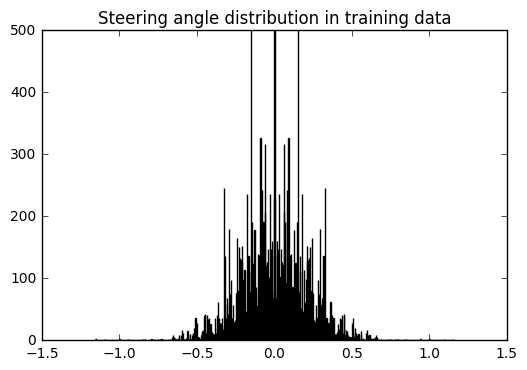

number of positive angle: 11525
number of negative angle: 11525
number of zero angle: 500


In [210]:
show_steering_angle_distribution(y_train)

positive_angle = [i for i in y_train if i > 0]
nagative_angle = [i for i in y_train if i < 0]
zero_angle = [i for i in y_train if i == 0]

print('number of positive angle:', len(positive_angle))
print('number of negative angle:', len(nagative_angle))
print('number of zero angle:', len(zero_angle))

### Choice only 3/4 of the data for training

In [211]:
# indices = random.sample(range(len(X_train)), round(len(X_train)*3/4))

# X_flag = X_flag[indices]
# X_train = X_train[indices]
# y_train = y_train[indices]

In [212]:
# show_steering_angle_distribution(y_train)

# positive_angle = [i for i in y_train if i > 0]
# nagative_angle = [i for i in y_train if i < 0]
# zero_angle = [i for i in y_train if i == 0]

# print('number of positive angle:', len(positive_angle))
# print('number of negative angle:', len(nagative_angle))
# print('number of zero angle:', len(zero_angle))

# Perprocess image to fit the Nvidia network input

In [213]:
def get_cropped_images(images):
    shape = images[0].shape
    height = shape[0]
    width = shape[1]
    return images[0:len(images), 65:height-35, 0:width]

def get_images_in_yuv(images):
    yuv_images = []
    for i in range(len(images)):
        yuv_images.append(cv2.cvtColor(images[i], cv2.COLOR_RGB2YUV))
    return np.array(yuv_images)

def get_resized_images(images):
    resized_images = []
    for i in range(len(images)):
        resized_images.append(cv2.resize(images[i].astype(np.uint8), (200, 66), cv2.INTER_AREA))
    return np.array(resized_images)

def get_blured_images(images):
    blured_images = []
    for i in range(len(images)):
        blured_images.append(cv2.bilateralFilter(images[i],5,50,50))
    return np.array(blured_images)

    

def preprocess_input(images):
    images = get_cropped_images(images)
    images = get_resized_images(images)
    images = get_images_in_yuv(images)
    images = get_blured_images(images)

    return images

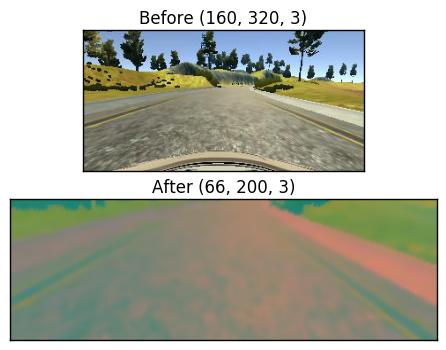

In [214]:
fig = plt.figure()

images = np.array([
    mpimg.imread(X_center[555])
])

a=fig.add_subplot(2,1,1)
imgplot = plt.imshow(images[0])
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
a.set_title('Before ' + str(images[0].shape))

preprocessed_images = preprocess_input(images)

a=fig.add_subplot(2,1,2)
imgplot = plt.imshow(preprocessed_images[0])
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
a.set_title('After ' + str(preprocessed_images[0].shape))

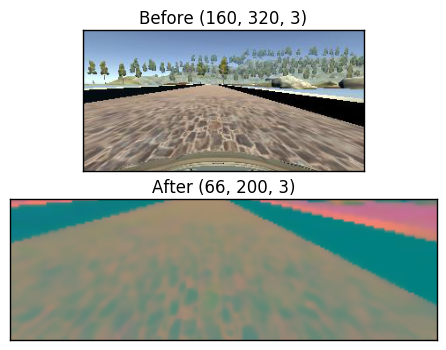

In [215]:
fig = plt.figure()

images = np.array([
    mpimg.imread(X_center[100])
])

a=fig.add_subplot(2,1,1)
imgplot = plt.imshow(images[0])
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
a.set_title('Before ' + str(images[0].shape))

preprocessed_images = preprocess_input(images)

a=fig.add_subplot(2,1,2)
imgplot = plt.imshow(preprocessed_images[0])
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
a.set_title('After ' + str(preprocessed_images[0].shape))

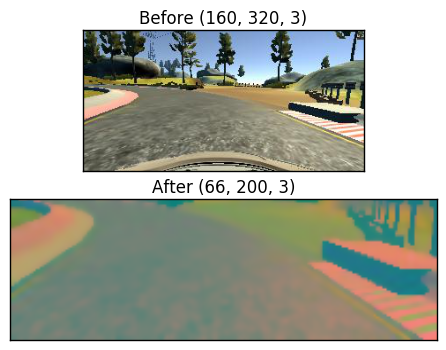

In [216]:
fig = plt.figure()

images = np.array([
    mpimg.imread(X_center[25])
])

a=fig.add_subplot(2,1,1)
imgplot = plt.imshow(images[0])
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
a.set_title('Before ' + str(images[0].shape))

preprocessed_images = preprocess_input(images)

a=fig.add_subplot(2,1,2)
imgplot = plt.imshow(preprocessed_images[0])
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
a.set_title('After ' + str(preprocessed_images[0].shape))

# Saving

In [218]:
out_file = open('driving_data.csv', 'w')
for i in range(len(X_train)):
    out_file.write(X_train[i] + ", " + str(X_flag[i]) + ", " + str(y_train[i]) + "\n")
out_file.close()